In [ ]:
import pandas as pd
import numpy as np
import os
import importlib
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
plt.style.use('default')
warnings.filterwarnings('ignore')

In [5]:
# user-defined function to check library is installed or not, if it is not installed then it will install automatically at runtime.
def check_and_install_library(library_name):
    try:
        importlib.import_module(library_name)
        print(f"{library_name} is already installed.")
    except ImportError:
        print(f"{library_name} is not installed. Installing...")
        try:
            import pip
            pip.main(['install', library_name])
        except:
            print("Error: Failed to install the library. Please install it manually.")

In [7]:
if 'sentiment140' not in os.listdir():
  check_and_install_library('opendatasets')
  import opendatasets as od
  dataset_url='https://www.kaggle.com/datasets/kazanova/sentiment140'
  od.download(dataset_url)

In [8]:
features_name=['target','ids','date','flag','user','text']
data=pd.read_csv('sentiment140/training.1600000.processed.noemoticon.csv',names=features_name,encoding='ISO-8859-1')

In [9]:
#checkout top 5 rows
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
#print concise summary about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
#check for missing values
data.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [12]:
#check for duplicate records
data[data.duplicated()].shape[0]

0

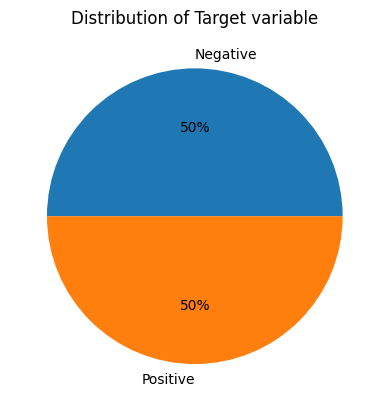

In [13]:
#check the distribution of target variable
plt.pie(data['target'].value_counts(),autopct='%2.f%%',labels=['Negative','Positive'])
plt.title('Distribution of Target variable')
plt.show()

our dataset is balanced it has equal tweets for each class

In [14]:
#check the distribution of flag feature:
data['flag'].value_counts()

NO_QUERY    1600000
Name: flag, dtype: int64

for sentiment analysis of tweets we required only tweet text and target feature so i am dropping all unnecessary features from the dataset.

In [15]:
#for sentiment analysis / prediction of tweets we required only tweet text and target feature,
#so i am taking only these two features and leaving all unnecessary features from the dataset.
data=data[['text','target']]

In [16]:
#checkout top 5 tweets
data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


Data Manipulation

In [17]:
data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Description about Target variable :
0 == negative and 4 == positive

In [18]:
#lets replace 4 with 1 to make it more convenient
data['target']=data['target'].replace(4,1)

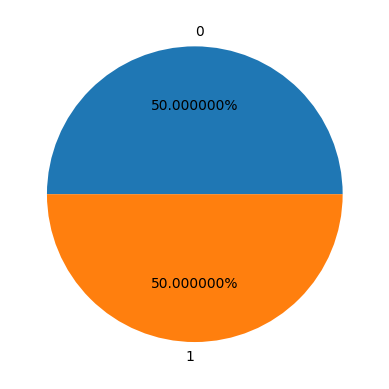

In [19]:
target_counts=data['target'].value_counts()
plt.pie(target_counts.values,autopct='%2f%%',labels=target_counts.index)
plt.show()

In [20]:
#out dataset is massive so lets take total 40k samples for sentiments ( for each each class 20k samples )
negative_tweets=data[data['target']==0].sample(20000)
positive_tweets=data[data['target']==1].sample(20000)
#and combine both class samples
sentiments=pd.concat([negative_tweets,positive_tweets],ignore_index=True)
sentiments.rename(columns={'text':'tweet'},inplace=True)

In [21]:
sentiments.head()

,tweet,target
0,I want to do something today besides wash my w...,0
1,@etrangle http://twitpic.com/6bmf7 - omg! i pr...,0
2,@Madderdin You broke my heart xD,0
3,It seems that all technology is determined to ...,0
4,Lil Santi is about to hit 200000 miles. And no...,0


In [22]:
#convert all the tweet text into lower case
sentiments['tweet']=sentiments['tweet'].str.lower()

In [23]:
#as we can see all the tweets are convert into lower case
sentiments.head(5)

,tweet,target
0,i want to do something today besides wash my w...,0
1,@etrangle http://twitpic.com/6bmf7 - omg! i pr...,0
2,@madderdin you broke my heart xd,0
3,it seems that all technology is determined to ...,0
4,lil santi is about to hit 200000 miles. and no...,0


Now its time for text proccessing using NLTK library

In [24]:
import nltk
#download stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
#Get the list of english language stopwords from the nltk corpus
from nltk.corpus import stopwords
english_stopwords=stopwords.words('english')
STOPWORDS=set(english_stopwords)

In [26]:
#clean/remove stopwords from the tweets
def clean_stopwords(text):
  value=' '.join(word for word in text.split() if word not in STOPWORDS)
  return value

In [27]:
#apply clean_stopwords function on tweet to remove the stopwords.
sentiments['tweet']=sentiments['tweet'].apply(lambda x: clean_stopwords(x))

In [28]:
import string
english_punctuations=string.punctuation
print(english_punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [29]:
#clearning and removing punctuations
import string
english_punctuations=string.punctuation

punctuation_list=english_punctuations

def cleaning_punctuations(text):
    translator=str.maketrans('', '',punctuation_list)
    return text.translate(translator)

sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_punctuations(text))

In [30]:
#check top 10 tweets after stopwords and punctuation removal to make sure we have successfully cleaned the tweet
sentiments.head(10)

,tweet,target
0,want something today besides wash work clothes...,0
1,etrangle httptwitpiccom6bmf7 omg pray fine br...,0
2,madderdin broke heart xd,0
3,seems technology determined fuck today even ip...,0
4,lil santi hit 200000 miles one car me,0
5,sofisticat hey saw inspiration today,0
6,danielayala thanks encouraging words better to...,0
7,cant get sleep,0
8,brightlydusted whats wrong dad hope turns alright,0
9,vichick people chatting screen confusing,0


In [31]:
sentiments.shape

(40000, 2)

In [32]:
import re
#cleaning and removing repeated charecters:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+',r'1',text)

sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_repeating_char(text))
sentiments.head()

,tweet,target
0,want something today besides wash work clothes...,0
1,etrangle httptwitpiccom6bmf7 omg pray fine br...,0
2,madderdin broke heart xd,0
3,seems technology determined fuck today even ip...,0
4,lil santi hit 200000 miles one car me,0


In [33]:
#cleaning removing URL from tweet
def cleaning_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)

sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_url(text))
sentiments.head()

,tweet,target
0,want something today besides wash work clothes...,0
1,etrangle httptwitpiccom6bmf7 omg pray fine br...,0
2,madderdin broke heart xd,0
3,seems technology determined fuck today even ip...,0
4,lil santi hit 200000 miles one car me,0


In [34]:
#clearning and removing numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '',text)

sentiments["tweet"]=sentiments["tweet"].apply(lambda text: cleaning_numbers(text))
sentiments.head()

,tweet,target
0,want something today besides wash work clothes...,0
1,etrangle httptwitpiccombmf omg pray fine brea...,0
2,madderdin broke heart xd,0
3,seems technology determined fuck today even ip...,0
4,lil santi hit miles one car me,0


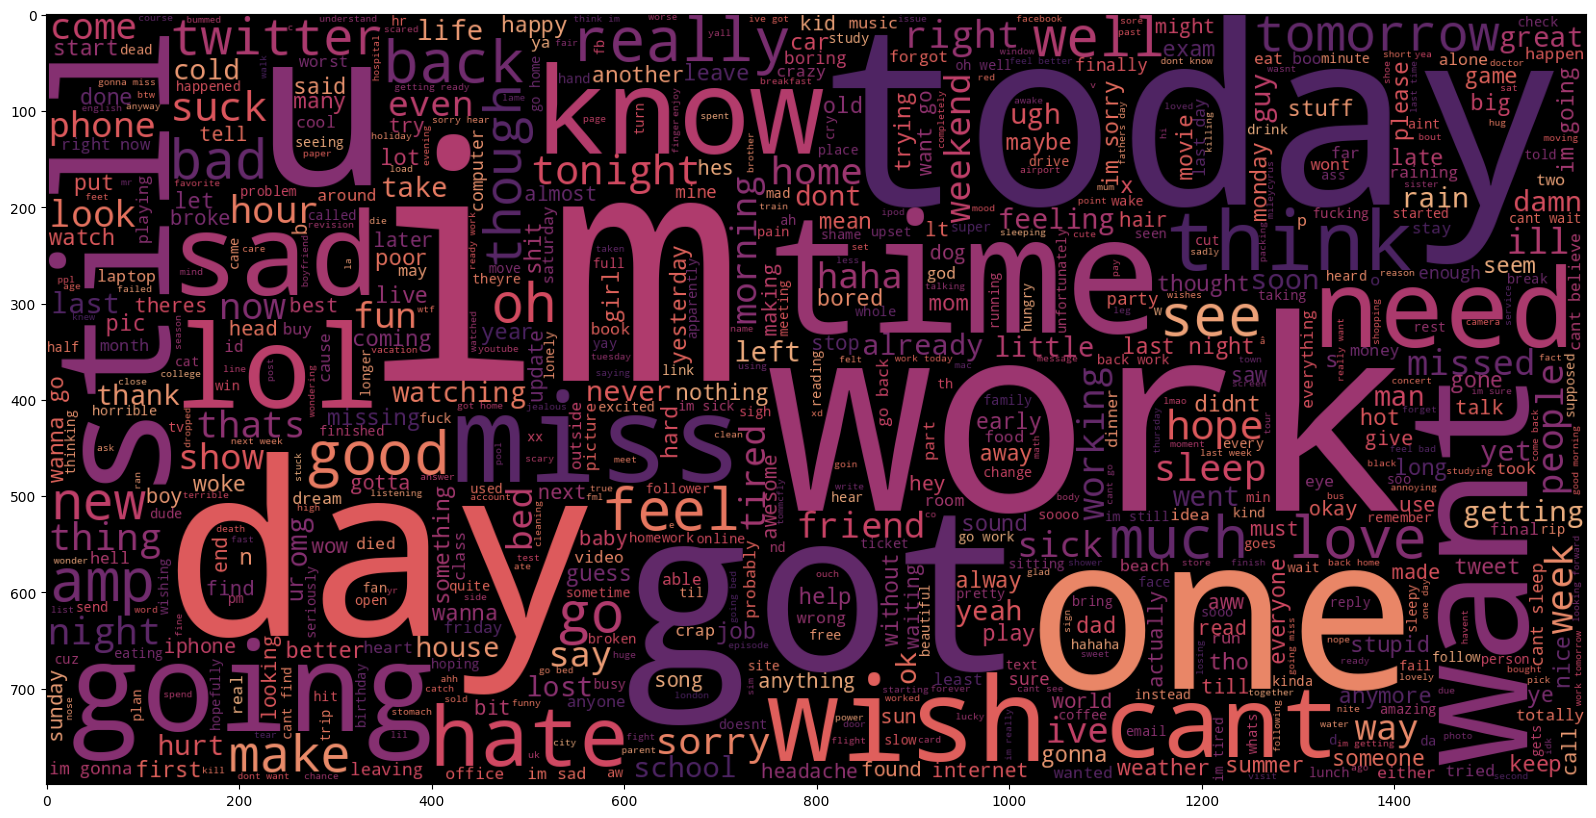

In [35]:
#plot cloud of words for negative class
negative_tweets=sentiments[sentiments["target"]==0]["tweet"]
plt.figure(figsize=(20,10))
from wordcloud import WordCloud

wc= WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare').generate(' '.join(np.array(negative_tweets)))
plt.imshow(wc)
plt.show()

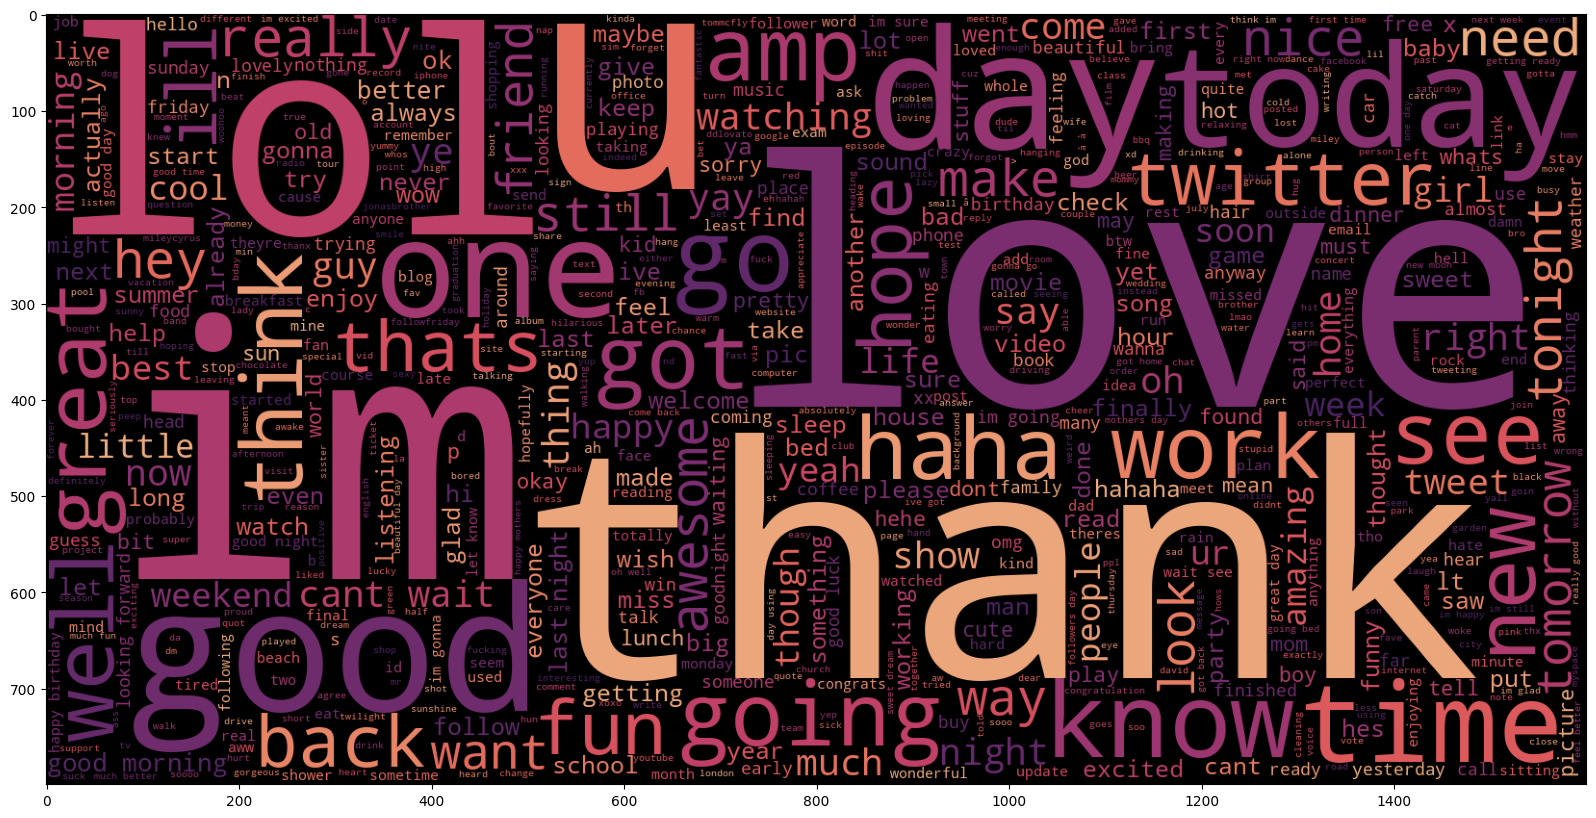

In [36]:
#plot cloud of words for positive class
positive_tweets=sentiments[sentiments["target"]==1]["tweet"]
plt.figure(figsize=(20,10))

wc= WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare').generate(' '.join(np.array(positive_tweets)))
plt.imshow(wc)
plt.show()

In [37]:
sentiments.head()

,tweet,target
0,want something today besides wash work clothes...,0
1,etrangle httptwitpiccombmf omg pray fine brea...,0
2,madderdin broke heart xd,0
3,seems technology determined fuck today even ip...,0
4,lil santi hit miles one car me,0


In [38]:
#word tokenization of tweet
from nltk.tokenize import word_tokenize
sentiments["tweet"]=sentiments["tweet"].apply(word_tokenize)
sentiments.head()

,tweet,target
0,"[want, something, today, besides, wash, work, ...",0
1,"[etrangle, httptwitpiccombmf, omg, pray, fine,...",0
2,"[madderdin, broke, heart, xd]",0
3,"[seems, technology, determined, fuck, today, e...",0
4,"[lil, santi, hit, miles, one, car, me]",0


In [39]:
#apply lemmatizer on sentiments.
nltk.download('wordnet')
lm=nltk.WordNetLemmatizer()

def lemmatizer_on_word(text):
    data=[lm.lemmatize(word) for word in text]
    return data
sentiments["tweet"]=sentiments["tweet"].apply(lambda text:lemmatizer_on_word(text))
sentiments.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,tweet,target
0,"[want, something, today, besides, wash, work, ...",0
1,"[etrangle, httptwitpiccombmf, omg, pray, fine,...",0
2,"[madderdin, broke, heart, xd]",0
3,"[seems, technology, determined, fuck, today, e...",0
4,"[lil, santi, hit, mile, one, car, me]",0


In [40]:
#remove commma and convert tokens into string before fitting to the model (it's depends on model to model)
sentiments["tweet"]=[" ".join(line)for line in sentiments["tweet"]]

In [41]:
sentiments.head(2)

,tweet,target
0,want something today besides wash work clothes...,0
1,etrangle httptwitpiccombmf omg pray fine break...,0


In [42]:
#spliting data into train and test subsets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(sentiments["tweet"],sentiments["target"],test_size=0.2,random_state=43)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((32000,), (8000,), (32000,), (8000,))

Model 1 : Logistic Regression

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
lr_model = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("logistic", LogisticRegression(C=1,solver='lbfgs',max_iter=100)) # model the text
])

lr_model.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic', LogisticRegression(C=1))])

In [44]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
#function to make prediction and evaluate the performance of the model.
def predict_and_evaluate_model_performance(model,test_data):
    y_pred=model.predict(test_data)
    print("Training Score : ",model.score(x_train,y_train))
    print("validation Score : ",accuracy_score(y_test,y_pred))
    print("Precision Score : ",precision_score(y_test,y_pred))
    print("Recall Score : ",recall_score(y_test,y_pred))
    print("F1 Score : ",f1_score(y_test,y_pred))
    print("="*100)
    print("Classification Report : ",classification_report(y_test,y_pred))
    print("="*100)
    cm=confusion_matrix(y_test,y_pred)
    print(cm)

In [45]:
#this method takes model and test data as an argument.
predict_and_evaluate_model_performance(lr_model,x_test)

Training Score :  0.851
validation Score :  0.74175
Precision Score :  0.7346789883268483
Recall Score :  0.756006006006006
F1 Score :  0.7451899358658116
Classification Report :                precision    recall  f1-score   support

           0       0.75      0.73      0.74      4004
           1       0.73      0.76      0.75      3996

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000

[[2913 1091]
 [ 975 3021]]


Model 2 : BernoulliNB

In [46]:
from sklearn.naive_bayes import BernoulliNB
nb_model=Pipeline([
        ("tfidf",TfidfVectorizer()),
        ("bernominal",BernoulliNB())
])

nb_model.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('bernominal', BernoulliNB())])

In [47]:
#this method takes model and test data as an argument.
predict_and_evaluate_model_performance(nb_model,x_test)

Training Score :  0.8951875
validation Score :  0.729625
Precision Score :  0.7460402684563758
Recall Score :  0.6954454454454454
F1 Score :  0.7198549410698095
Classification Report :                precision    recall  f1-score   support

           0       0.72      0.76      0.74      4004
           1       0.75      0.70      0.72      3996

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000

[[3058  946]
 [1217 2779]]


Model 3 : XGBoost

In [48]:
from xgboost import XGBClassifier
xg_model=Pipeline([
        ("tfidf",TfidfVectorizer()),
        ("xgboost",XGBClassifier())
])
xg_model.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [49]:
#this method takes model and test data as an argument.
predict_and_evaluate_model_performance(xg_model,x_test)

Training Score :  0.77059375
validation Score :  0.709625
Precision Score :  0.6752566520008381
Recall Score :  0.8065565565565566
F1 Score :  0.7350895198996464
Classification Report :                precision    recall  f1-score   support

           0       0.76      0.61      0.68      4004
           1       0.68      0.81      0.74      3996

    accuracy                           0.71      8000
   macro avg       0.72      0.71      0.71      8000
weighted avg       0.72      0.71      0.71      8000

[[2454 1550]
 [ 773 3223]]
